<h1 style="text-align:center;">Waste Classification - CNN - Keras & Tensorflow <h1>

## @Author: Group 1 - AWT306

Lu Quoc Khai Ho - A00096112

In [39]:
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
from PIL import Image

import tensorflow as tf
import keras
# from tensorflow.keras.applications import MobileNetV2


from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# tf.config.optimizer.set_jit(True) # optimize keras trainning process

## Defining variables and reusable functions

In [40]:
# Define dataset folder
current_dir = os.path.dirname(os.path.abspath("__file__"))
data_dir =  current_dir + "/dataset"

# Set the testing directory path for model prediction
testing_dir = current_dir + "/test"

In [41]:
image_count = len(glob.glob(f'{data_dir}/*/*'))
print(f"Total images: {image_count}") # Count total images in dataset folder

Total images: 85755


### Visualize trainning result

In [42]:
def visualize_training_result():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Load data using a Keras utility

## Generate more dataset

This function is used to generate the images for the mall dataset which uses the same method with data augmentation and save data to each label folder

In [43]:
#generate images from existed dataset
def generate_dataset_image(dataset_path, number_images):
    print("Images are generating... ")
    datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest'
    )
    
    subfolders = glob.glob(f"{dataset_path}/*")
    
    labels = []
    
    for path in subfolders:
        label = path.split("/")[-1]
        files = glob.glob(f"{path}/*")
        j = 0
        for file in files:
            img = keras.utils.load_img(file)  # this is a PIL image
            x = keras.utils.img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
            x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
    
            # the .flow() command below generates batches of randomly transformed images
            # and saves the results to the `preview/` directory
            i = 0
            for batch in datagen.flow(x, batch_size=1,
                                      save_to_dir=f'{dataset_path}/{label}', save_prefix=f'generated.{j}.{label}', save_format='jpeg'):
                i += 1
                if i > (number_images - 1): # generate 1 image 3 times
                    break  # otherwise the generator would loop indefinitely
            j += 1
        
    print("Images generating is completed!")


In [44]:
# generate_dataset_image(data_dir, 3)

In [45]:
image_count = len(glob.glob(f'{data_dir}/*/*'))
print(f"total images: {image_count}")

total images: 85755


### Define some parameters for the loader:

In [46]:
batch_size = 32

img_height = 124
img_width = 124

In [47]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 85750 files belonging to 4 classes.
Using 68600 files for training.


In [48]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 85750 files belonging to 4 classes.
Using 17150 files for validation.


In [49]:
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)

['glass', 'metal', 'paper', 'plastic']


## Visualize the data

Testing image that fit to the label in random 1 batch dataset

2024-11-26 08:40:31.935973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


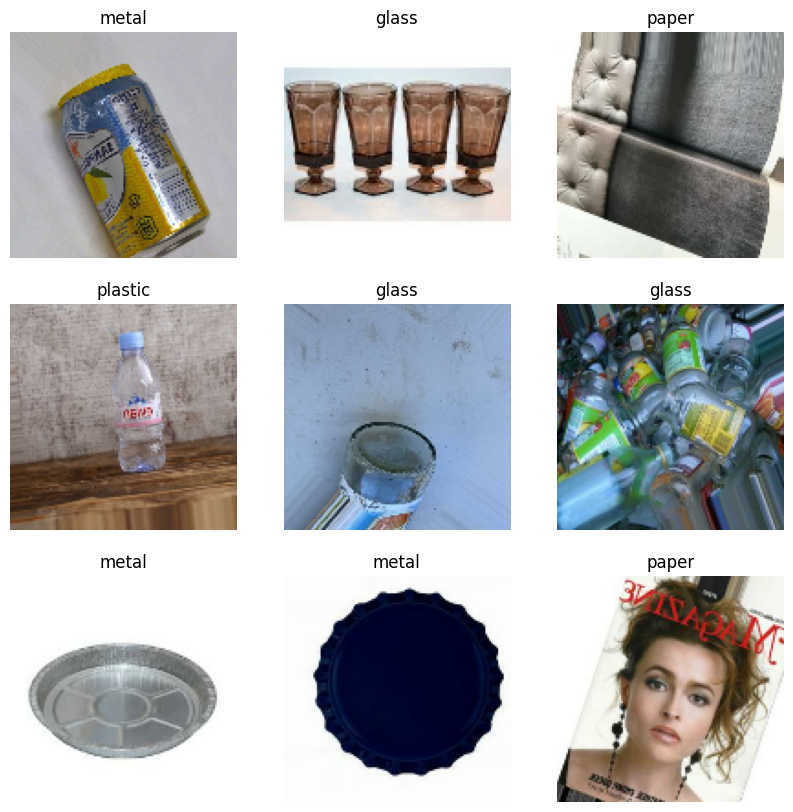

In [50]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [51]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 124, 124, 3)
(32,)


## Configure the dataset for performance

In [52]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(5000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Optimization for Training and Validation Datasets by caching and shuffling
# train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
# val_ds = val_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

In [53]:
# prefetching the training data to optimize pipeline
# train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

## Standardize the data

In [54]:
normalization_layer = layers.Rescaling(1./255)

In [55]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

2024-11-26 08:40:38.661081: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 08:40:45.903070: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: extra compressed data
2024-11-26 08:40:46.190029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:85: Filling up shuffle buffer (this may take a while): 1103 of 5000


0.0 1.0


2024-11-26 08:40:54.616059: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


# Overfitting Solutions

## 1. Data augmentation

In [56]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

# # Apply data_augmentation to the training images.
# train_ds = train_ds.map(
#     lambda img, label: (data_augmentation(img), label),
#     num_parallel_calls=tf.data.AUTOTUNE,
# )
# # Prefetching samples in GPU memory helps maximize GPU utilization.
# train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
# val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

/opt/tensorflow/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2024-11-26 08:41:00.010414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


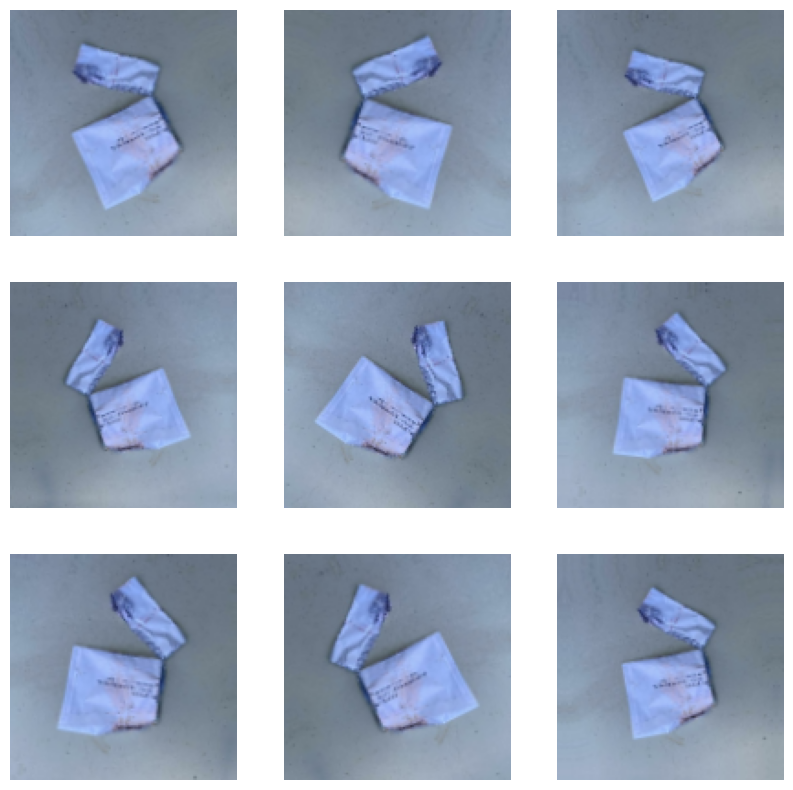

In [57]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [58]:
# model = Sequential([
#     data_augmentation,
#     layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#     data_augmentation,
#     layers.Conv2D(32, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
    
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
    
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.25),
#     layers.Flatten(),
    
#     layers.Dense(256, activation='relu'),
    
#     layers.Dense(num_classes)
# ])

In [103]:
dropout_rate = 0.2
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(dropout_rate),
    layers.Dense(num_classes, name="outputs")
])

In [104]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
    # optimizer='adam',
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [105]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 124, 124, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 62, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 31, 31, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,737,092 (6.63 MB)

 Trainable params: 1,737,092 (6.63 MB)

 Non-trainable params: 0 (0.00 B)

In [106]:
epochs=100
early_stopping = keras.callbacks.EarlyStopping( monitor='val_loss',          
    mode='min',                   
    min_delta=0.01,              
    verbose=1,                    
    patience=10,                 
    restore_best_weights=True     
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    shuffle=True,
    batch_size=batch_size,
    callbacks=[early_stopping]
)

Epoch 1/100
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.4576 - loss: 1.1920 - val_accuracy: 0.6225 - val_loss: 0.9248
Epoch 2/100
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.6352 - loss: 0.8980 - val_accuracy: 0.6721 - val_loss: 0.8267
Epoch 3/100
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.6946 - loss: 0.7821 - val_accuracy: 0.6514 - val_loss: 0.8687
Epoch 4/100
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.7266 - loss: 0.7040 - val_accuracy: 0.7055 - val_loss: 0.7707
Epoch 5/100
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.7432 - loss: 0.6617 - val_accuracy: 0.7184 - val_loss: 0.7370
Epoch 6/100
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.7604 - loss: 0.6246 - val_accuracy: 0.7506 - val_loss: 0.6443
Epoch 7/100
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.7730 - loss: 0.5928 - val_accuracy: 0.7626 - val_loss: 0.6245
Epoch 8/100
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.7869 -

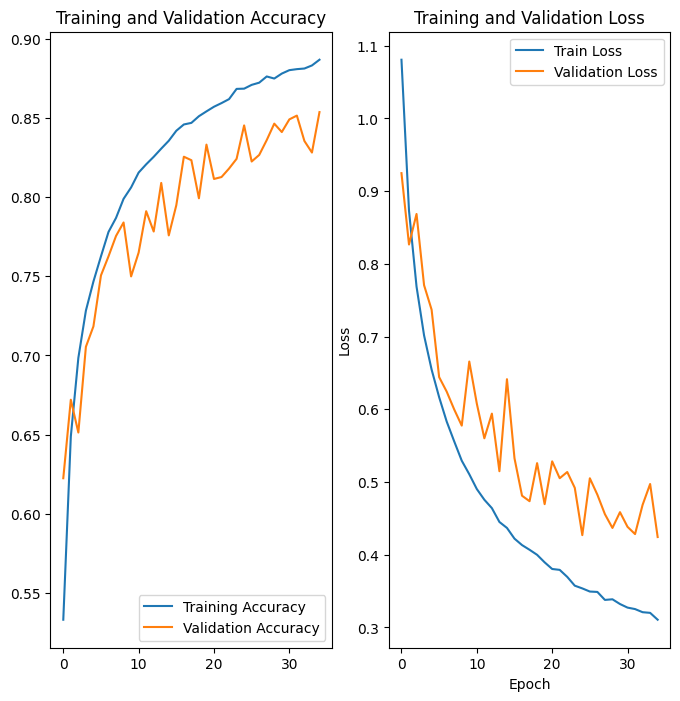

In [108]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"],label = "Train Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Save Keras model

In [131]:
model.save(f'{current_dir}/AWT306_Group1_CNN_Model.keras')
model.export('model_export')

INFO:tensorflow:Assets written to: model_export/assets


INFO:tensorflow:Assets written to: model_export/assets


Saved artifact at 'model_export'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 124, 124, 3), dtype=tf.float32, name='keras_tensor_390')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  132018005487888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132018005483472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132018138122768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132018138134864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132018005479056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132018005489232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132018005486352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132018005485584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132018005488272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132018005488848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13201800547694

## Load Keras Model

In [110]:
group1_cnn_model = tf.keras.models.load_model(f'{current_dir}/AWT306_Group1_CNN_Model.keras')

# Show the model architecture
group1_cnn_model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 124, 124, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 62, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 31, 31, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,211,278 (19.88 MB)

 Trainable params: 1,737,092 (6.63 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,474,186 (13.25 MB)

## Predict on new data

In [111]:
import math
def resize_display_image(path, width):
    img = None
    if len(path):
        # Read the Image
        image = Image.open(path)
        ratio = (width/image.width)

        # Resize the image using resize() method
        image = image.resize((width, math.ceil(image.height * ratio)))
        
    return image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
tf.Tensor([9.9891055e-01 3.2135122e-05 5.1294634e-04 5.4438913e-04], shape=(4,), dtype=float32)
['glass', 'metal', 'paper', 'plastic']
This image most likely belongs to glass with a 99.89 percent confidence.


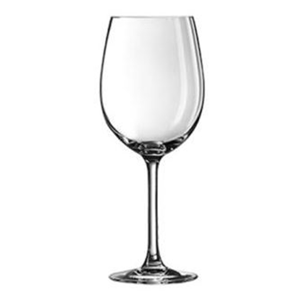

In [117]:
import random

animals = list(glob.glob(f'{testing_dir}/*'))

# Select a random item
#selected_item = random.choice(animals)
selected_item = testing_dir + '/CA0075003-_Wine-Glass-Breeze-350ml1.jpg'
img = tf.keras.utils.load_img(
    selected_item, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
# img_array = img_array/255.0

predictions = group1_cnn_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(score)
print(class_names)

# print(f"This image is {100 * (1 - score):.2f}% {class_names[np.argmax(score)]} and {100 * score:.2f}% dog.")

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

# PIL.Image.open(str(selected_item))
resize_display_image(str(selected_item),300)

## Convert the Keras Sequential model to a TensorFlow Lite model

In [82]:
print(model)

<Sequential name=sequential_4, built=True>


In [83]:
print(model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 124, 124, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 62, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 31, 31, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,440,526 (77.97 MB)

 Trainable params: 6,813,508 (25.99 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,627,018 (51.98 MB)

None


In [119]:
# Convert the model.
# converter = tf.lite.TFLiteConverter.from_keras_model(group1_cnn_model)
# # converter.target_spec.supported_ops = [
# #   tf.lite.OpsSet.TFLITE_BUILTINS, # enable LiteRT ops.
# #   tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
# # ]
# tflite_model = converter.convert()

# # Save the model.
# with open('converted_model.tflite', 'wb') as f:
#   f.write(tflite_model)

In [132]:
converter = tf.lite.TFLiteConverter.from_saved_model('model_export')
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable LiteRT ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()
open("awt306_model.tflite", "wb").write(tflite_model)

W0000 00:00:1732614475.013307    1864 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1732614475.013335    1864 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-11-26 09:47:55.013530: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: model_export
2024-11-26 09:47:55.014695: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-11-26 09:47:55.014706: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: model_export
2024-11-26 09:47:55.032795: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-11-26 09:47:55.089708: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: model_export
2024-11-26 09:47:55.110878: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 97350 microseconds.
2024-11-26 09:47:55.264280: W tensorflow/compiler/mlir/li

6971164

# Run the TensorFlow Lite model

In [133]:
TF_MODEL_FILE_PATH = 'awt306_model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

2024-11-26 09:48:06.969655: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-26 09:48:06.969947: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-26 09:48:06.970164: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [134]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['keras_tensor_390'], 'outputs': ['output_0']}}

In [135]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [136]:
predictions_lite = classify_lite(keras_tensor_390=img_array)['output_0']
score_lite = tf.nn.softmax(predictions_lite)

In [137]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to glass with a 100.00 percent confidence.


In [138]:
print(np.max(np.abs(predictions - predictions_lite)))

4.8888826
